# Import necessary libraries

In [ ]:

# !pip install yfinance  # to fetch the financial data
# !pip install pandas_ta  # to create the indicators with pandas data frame
# !pip install torch  # we will be using torch as a back end for Keras ==3
# !pip install keras==3.0.0  # Keras 3.0 now supports pytorch as a backend as well
# !pip install livelossplot  # to plot live accuracy and loss plots while training


Set Torch as backend

In [1]:
import os
import torch
os.environ["KERAS_BACKEND"] = "torch"

We will confirm it is using a GPU

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Import essential libraries

In [3]:
import yfinance as yf
import datetime
import keras
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data
# from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model

# Download the historical data from Yahoo finance for 15 years data, replace  'days=15' to change the years accordingly

In [4]:
# ticker_symbol = "RELIANCE.NS"
ticker_symbol = "^NSEI"

start_date = datetime.datetime.now() - datetime.timedelta(days=15 * 365)
end_date = datetime.datetime.now()

df1 = yf.download(ticker_symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
# using yfinance download weekly data instead of daily for last 15 years for ticker "^NSEI"
# ticker_symbol = "^NSEI"
# df2 = yf.download(ticker_symbol, period="15y", interval="1wk")

# # drop adjusted close column and volume column
# df2 = df2.drop(['Adj Close', 'Volume'], axis=1)
# #Calculate percentage returns  for df2 
# df2 = df2.pct_change()
# df2 = df2.dropna()
# df2['target'] = (df2['Close'].shift(-1) > 0).astype(int)

Create a backup copy to reset the experiment

In [91]:
df = df1.copy()
#df = df2.copy()

# Alternate method to download historical data You need Alpha Vantage free API key. Store that key in the text folder and replace the path. For this script I have Used  the Yahoo finance data the only difference will be the column name which will be capitalized Or in small letters

In [ ]:
#!pip install pandas-dataloader
#from pandas_datareader import data
# Download stock market data (e.g., Apple Inc.)
# with open('G:/anaconda/Scripts/data/alpha_vantage/key.txt', 'r') as f:
#     key = f.read()
# symbol = 'AAPL'  # Ticker symbol for Apple Inc.
# df = data.DataReader(symbol, "av-daily", start=datetime(2017, 2, 9),
#                     end=datetime(2024, 2, 26),
#                     api_key=key)

# We will try to normalize the values without calculating the returns. It just for the demonstration to see how it will be difficult for the LSTM model to learn effectively

# Let's plot raw closing data 1st

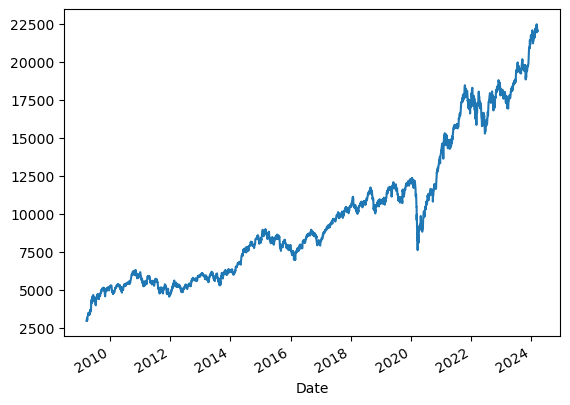

In [8]:
df['Close'].plot()
plt.show()

# Now we will normalize it without making the data stationary

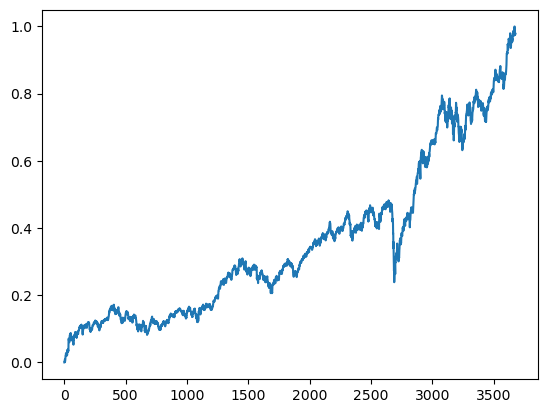

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_test = df.copy()
scaled_data = scaler.fit_transform(df_test[['Open', 'High', 'Low', 'Close','Volume']])
plt.plot(scaled_data[:, 3])

# Create Various columns with indicators based on pandas_ta  library. It is deterministic approach and we will use binary output as features. After experimentation it doesn't work well since it's too simple for deep neural networks and they memorize the training data

In [ ]:
# df['sma_small_delta'] = np.where(df.ta.sma(length=5) > df.ta.sma(length=10),1,0)
# df['wma_small_delta'] = np.where(df.ta.wma(length=10) > df.ta.wma(length=20),1,0)
# df['sma_long_delta'] = np.where(df.ta.sma(length=20) > df.ta.sma(length=50),1,0)
# df['rsi_delta'] = np.where(df.ta.rsi(length=7) > df.ta.rsi(length=14),1,0)
# df['vwma_small_delta'] = np.where(df.ta.vwma(length=5) > df.ta.vwma(length=10),1,0)
# df['vwma_long_delta'] = np.where(df.ta.vwma(length=10) > df.ta.vwma(length=20),1,0)
#df['percent_return_20'] = df.ta.percent_return(length=20)
# df_vortex = df.ta.vortex(length=14)  # Vortex indicator has two oscillators positive and negative. We calculate the delta
# df_vortex['plus_delta'] = np.where(df_vortex['VTXP_14'] > df_vortex['VTXM_14'],1,0)
# df['vortex_plus_delta'] = df_vortex['plus_delta']


# Create columns based on pandas_ta library, non binary method that is more noise but more opportunities to learn the pattern

In [92]:
import pandas_ta as ta
df['sma_small_delta'] = (df.ta.sma(length=5) - df.ta.sma(length=10))/df.ta.sma(length=10)
df['wma_small_delta'] = (df.ta.wma(length=10) - df.ta.wma(length=20))/df.ta.wma(length=20)
df['sma_long_delta'] = (df.ta.sma(length=20) - df.ta.sma(length=50))/df.ta.sma(length=50)
df['rsi_delta'] = (df.ta.rsi(length=7) - df.ta.rsi(length=14)) / df.ta.rsi(length=14)
df['vwma_small_delta'] = (df.ta.vwma(length=5) - df.ta.vwma(length=10))/df.ta.vwma(length=10) # Volume weighted moving average
df['vwma_long_delta'] = (df.ta.vwma(length=10) - df.ta.vwma(length=20))/df.ta.vwma(length=20)
df['percent_return_20'] = df.ta.percent_return(length=20)
# vortex as has a skew so we ommited
# df_vortex = df.ta.vortex(length=14)  # Vortex indicator has two oscillators positive and negative. We calculate the delta
# df_vortex['plus_delta'] = (df_vortex['VTXP_14'] - df_vortex['VTXM_14'])/df_vortex['VTXM_14']
# df['vortex_plus_delta'] = df_vortex['plus_delta']
df['atr'] = df.ta.atr()/df['Close']
df['roc5'] = df.ta.roc(length=5)
df['roc'] = df.ta.roc()
df= df.dropna()


# plot any one indicator to confirm stationary properties

<Axes: xlabel='Date'>

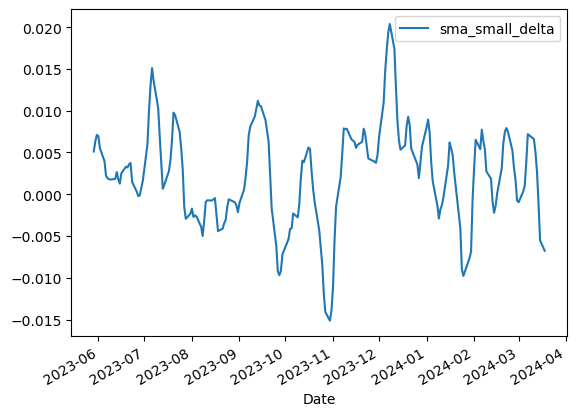

In [34]:
df[['sma_small_delta']].tail(200).plot() # Zoom in view to see if there is randomness or some cyclical pattern


# Now we will normalize the data that is the indicators we just created so it will have a similar scale

In [93]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [94]:
print(df.columns.to_list())

['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'sma_small_delta', 'wma_small_delta', 'sma_long_delta', 'rsi_delta', 'vwma_small_delta', 'vwma_long_delta', 'percent_return_20', 'atr', 'roc5', 'roc']


In [95]:
columns_to_norm = ['sma_small_delta', 'wma_small_delta', 'sma_long_delta', 'rsi_delta', 'vwma_small_delta', 'vwma_long_delta', 'percent_return_20', 'atr', 'roc5', 'roc']
#columns_to_norm = ['All_Candle_Patterns']

for col in columns_to_norm:
    df[[col]] = scaler.fit_transform(df[[col]])


C:\Users\alex1\AppData\Local\Temp\ipykernel_17236\1369944331.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[[col]] = scaler.fit_transform(df[[col]])
C:\Users\alex1\AppData\Local\Temp\ipykernel_17236\1369944331.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[[col]] = scaler.fit_transform(df[[col]])
C:\Users\alex1\AppData\Local\Temp\ipykernel_17236\1369944331.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

## experiment #1
create binary target if tomorrow's close is higher than today's close then assign the value one else assign the value 0

In [75]:
# df['next_day_close'] = df['Close'].shift(-1)
# df['target'] = (df['next_day_close'] > df['Close']).astype(int)


# Experiment #2 
Create 5 day SMA, And if tomorrow's close is higher than five days mean including current days close then assign the value one is assign the value 0 for for target


In [76]:
# df['next_day_close'] = df['Close'].shift(-1)
# df['5sma_lag'] = df['Close'].rolling(5).mean()
# df['target'] = (df['next_day_close'] > df['5sma_lag']).astype(int)
# 
# df = df.dropna()


C:\Users\alex1\AppData\Local\Temp\ipykernel_17236\2887755221.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['next_day_close'] = df['Close'].shift(-1)
C:\Users\alex1\AppData\Local\Temp\ipykernel_17236\2887755221.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['5sma_lag'] = df['Close'].rolling(5).mean()
C:\Users\alex1\AppData\Local\Temp\ipykernel_17236\2887755221.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

# Experiment #3 
If next 5 days simple moving average is higher than current five days simple moving average then assign the value one else assign the value 0 for target

In [96]:
df['5sma_lag'] = df['Close'].rolling(5).mean()
df['5sma_next'] = df['5sma_lag'].shift(-5)

df['target'] = (df['5sma_next'] > df['5sma_lag']).astype(int)

df = df.dropna()



C:\Users\alex1\AppData\Local\Temp\ipykernel_17236\280214040.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['5sma_lag'] = df['Close'].rolling(5).mean()
C:\Users\alex1\AppData\Local\Temp\ipykernel_17236\280214040.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['5sma_next'] = df['5sma_lag'].shift(-5)
C:\Users\alex1\AppData\Local\Temp\ipykernel_17236\280214040.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

# drop unwanted columns

In [97]:
df = df.drop(['Open', 'High','Low', 'Close', 'Adj Close', 'Volume','5sma_lag','5sma_next'],axis=1)
# df = df.drop(['Open', 'High','Low', 'Close', 'Adj Close', 'Volume','5sma_lag','next_day_close'],axis=1)

# df = df.drop(['Open', 'High','Low', 'Close', 'Adj Close', 'Volume','next_day_close'],axis=1)



In [98]:
df = df.dropna()

# Create target and features

In [99]:
features = df.drop('target', axis=1).values
target = df['target'].values

Create the sequence of length 10 for LSTM model

In [100]:
def create_sequences(features, target, sequence_length):
    X = []
    y = []
    for i in range(len(features) - sequence_length):
        X.append(features[i:i+sequence_length])
        y.append(target[i+(sequence_length-1)])
    return np.array(X), np.array(y)

sequence_length = 10
X, y = create_sequences(features, target, sequence_length)

# split X and Y into training and validation sets

In [101]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4,shuffle=False)


In [102]:
print("Training shape:", X_train.shape)
print("Validation shape:", X_val.shape)

Training shape: (1632, 10, 10)
Validation shape: (1089, 10, 10)


In [103]:
num_features = X_train.shape[2]
print(num_features)

10


In [104]:
from keras.optimizers import Adam
from keras.regularizers import l1_l2,l1,l2
from keras.layers import LeakyReLU
# inputs = Input(shape=(sequence_length, X_train.sha))  # Replace with appropriate values


# Build the LSTM model
model = Sequential()
# model.add(LSTM(64, return_sequences=True, input_shape=(sequence_length, num_features), activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
#model.add(LSTM(64, return_sequences=True, input_shape=(sequence_length, num_features), activation='relu', kernel_regularizer=l1(0.001)))
# model.add(LSTM(152, return_sequences=True, activation='relu'))  # Add an extra LSTM layer
#model.add(Dropout(0.5))
#model.add(LSTM(92, return_sequences=True, activation='relu'))  # Add an extra LSTM layer
#model.add(Dropout(0.4))
model.add(LSTM(32, return_sequences=True, activation='relu',input_shape=(sequence_length, num_features) ))  # Add an extra LSTM layer
# # model.add(Dropout(0.4))
# model.add(LSTM(32, return_sequences=True, activation='relu'))  # Add an extra LSTM layer
# # model.add(Dropout(0.4))
# model.add(LSTM(8, return_sequences=True, activation='tanh'))  # Add an extra LSTM layer
# # # model.add(Dropout(0.4))
model.add(LSTM(8))  # Add an extra LSTM layer
# model.add(Dense(1, activation='sigmoid',  kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model.add(Dense(1, activation='sigmoid'))
optimizer = Adam(learning_rate=0.001) # default is 0.001
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

D:\anaconda\envs\deeplearning\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [105]:
early_stopping = EarlyStopping(monitor='val_loss',    # Monitor the val loss
                               patience=150,           # Num epochs; if no improvement training will be stopped
                               verbose=1,
                               mode='min',            # The training will stop when the quantity monitored has stopped decreasing
                               restore_best_weights=True) # Restores model weights from the epoch with the best value of the monitored quantity.

In [106]:

# Model checkpoint callback
model_checkpoint = ModelCheckpoint('/content/best_model.keras',   # Path where to save the model
                                   monitor='val_loss',   # Monitor the validation loss
                                   save_best_only=True,  # The latest best model according to the quantity monitored will not be overwritten
                                   mode='min',           # The training will save the model when the quantity monitored has decreased
                                   verbose=1)


In [108]:
from livelossplot import PlotLossesKeras
plot_losses = PlotLossesKeras()

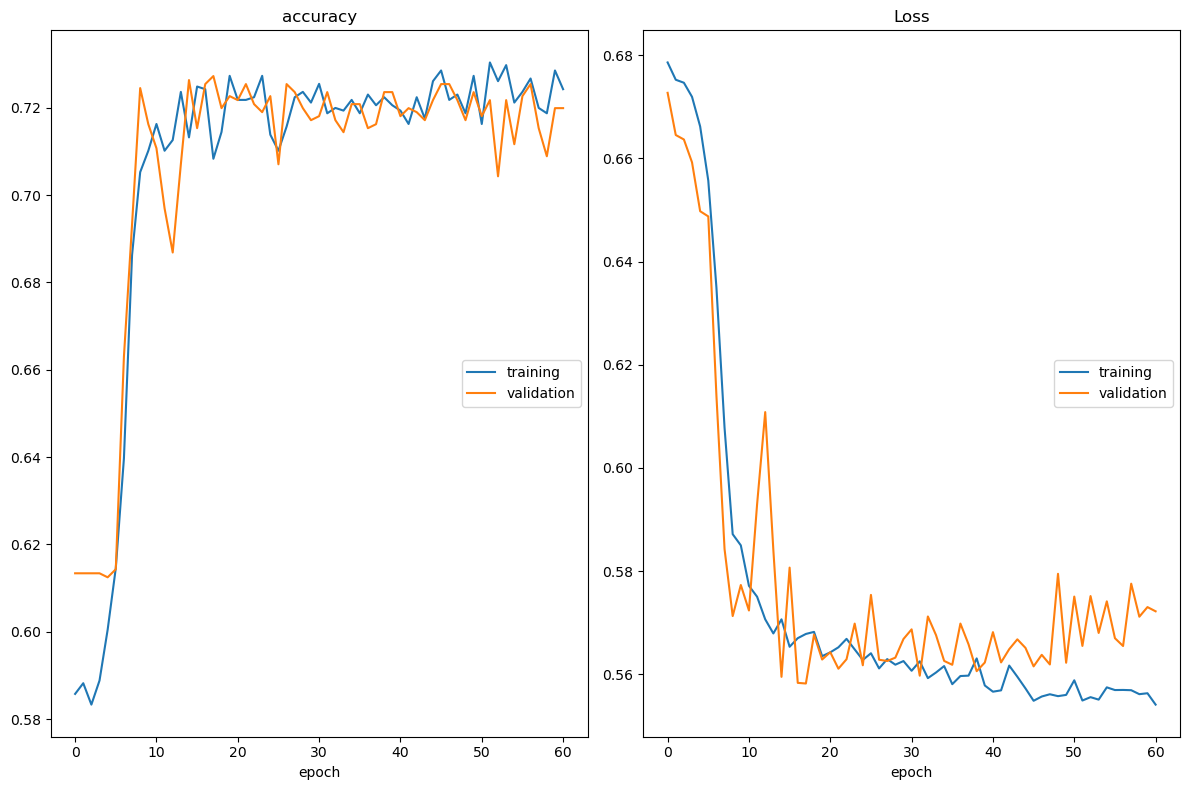

accuracy
	training         	 (min:    0.583, max:    0.730, cur:    0.724)
	validation       	 (min:    0.612, max:    0.727, cur:    0.720)
Loss
	training         	 (min:    0.554, max:    0.679, cur:    0.554)
	validation       	 (min:    0.558, max:    0.673, cur:    0.572)


KeyboardInterrupt: 

In [109]:
model.fit(X_train, y_train,
                    epochs=1000,
                    batch_size=4,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, model_checkpoint,plot_losses],
                    verbose=False)


#plot model architecture

In [ ]:
plot_model(model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)
